# Vision Transformers

[Paper here](https://arxiv.org/pdf/2010.11929)


In [ ]:
# %cd "Deep-Learning-From-Scratch/Generative Models/Pix2Pix"

In [1]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich

In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import CIFAR100
from torchvision.transforms import v2
from torchvision.utils import make_grid

# import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# wandb.require('core')
# wandb.login()

In [78]:
# Hyperparameters
NUM_CLASSES = 100
PATCH_SIZE = 4
NUM_BLOCKS = 12
DIM_EMBEDDING = 768
DIM_HIDDEN = DIM_EMBEDDING * 4
NUM_HEADS = 12
DROPOUT_RATE = 0.3
IMAGE_SHAPE = (3, 32, 32)

BATCH_SIZE = 64
N_EPOCHS = 50
LEARNING_RATE = 2e-4

## Load the dataset


In [5]:
true_labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm",
]


In [6]:
train_dataset = CIFAR100(
    root="./data/", download=True, train=True, transform=v2.ToImage()
)
test_dataset = CIFAR100(
    root="./data/", download=True, train=False, transform=v2.ToImage()
)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
mean_pixel_train = train_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_train = train_dataset.data.std(axis=(0, 1, 2)) / 255

mean_pixel_test = test_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_test = test_dataset.data.std(axis=(0, 1, 2)) / 255

(mean_pixel_train, std_pixel_train), (mean_pixel_test, std_pixel_test)



(
    (array([0.50707516, 0.48654887, 0.44091784]), array([0.26733429, 0.25643846, 0.27615047])),
    (array([0.50879641, 0.48739301, 0.44194221]), array([0.26825157, 0.25736374, 0.27709577]))
)

In [8]:
train_transform = v2.Compose(
    [
        v2.Resize((32)),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean_pixel_train, std_pixel_train),
    ]
)

test_transform = v2.Compose(
    [
        v2.Resize((32)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean_pixel_test, std_pixel_test),
    ]
)


In [37]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * torch.tensor(std_pixel, device=x.device).view(3, 1, 1) + torch.tensor(
        mean_pixel, device=x.device
    ).view(3, 1, 1)
    x = v2.ToPILImage()(x)

    return x

In [10]:
full_train_dataset = CIFAR100(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = CIFAR100(
    root="./data/", download=True, train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [13]:
len(train_loader), len(val_loader), len(test_loader)

(547, 235, 157)

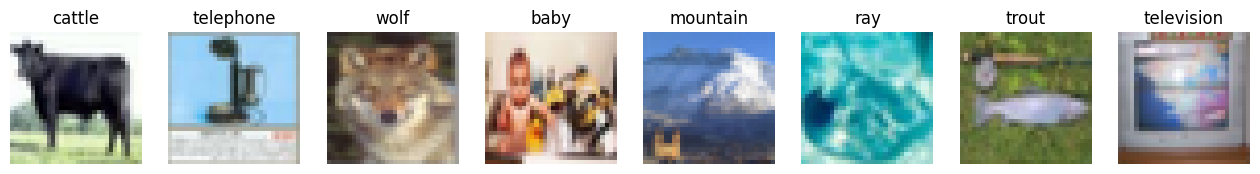

In [14]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img, train=True)
    axs[i].imshow(img)
    axs[i].set_title(f"{true_labels[label]}")
    axs[i].axis("off")

plt.show()


## Build the architecture

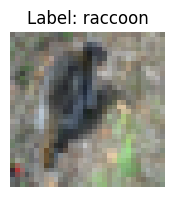

In [15]:
sample_image, sample_target = train_dataset[132]
plt.figure(figsize=(2, 5))
plt.imshow(reverse_transform(sample_image))
plt.title(f"Label: {true_labels[sample_target]}")
plt.axis("off")
plt.show()

In [57]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_embd, image_shape, dropout=0.0, debug=False):
        super(PatchEmbedding, self).__init__()

        self.patch_size = patch_size
        self.d_embd = d_embd

        self.n_channels, img_height, img_width = image_shape
        self.n_patches = (img_height // self.patch_size) * (
            img_width // self.patch_size
        )

        self.input_dim = self.n_channels * self.patch_size * self.patch_size

        self.projection = nn.Linear(self.input_dim, self.d_embd)

        # [CLASS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.d_embd))

        # Learnabled positional embedding
        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, self.d_embd)
        )

        self.dropout = nn.Dropout(dropout)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[EMBEDDING] Input")
        b, c, h, w = x.shape

        assert (
            h % self.patch_size == 0 and w % self.patch_size == 0
        ), "Invalid patch size"
        assert c == self.n_channels, "Invalid number of channels"

        # (B, C, H, W) -> (B, C, H // patch_size, patch_size, W // patch_size, patch_size)
        x = x.reshape(
            b,
            c,
            h // self.patch_size,
            self.patch_size,
            w // self.patch_size,
            self.patch_size,
        )
        # (B, C, H // patch_size, patch_size, W // patch_size, patch_size) -> (B, H // patch_size, W // patch_size, C, patch_size, patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5)
        # (B, H // patch_size, W // patch_size, C, patch_size, patch_size) -> (B, H // patch_size * W // patch_size, C * patch_size * patch_size)
        x = x.reshape(b, -1, self.input_dim)
        self._debug_print(x, "[EMBEDDING] Flattened")

        x = F.layer_norm(x, (self.input_dim,))
        x = self.projection(x)
        self._debug_print(x, "[EMBEDDING] Projected")
        x = F.layer_norm(x, (self.d_embd,))

        cls_token = self.cls_token.repeat(b, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        self._debug_print(x, "[EMBEDDING] CLS token")

        x += self.pos_embedding
        self._debug_print(x, "[EMBEDDING] POS embedding")

        x = self.dropout(x)

        return x

In [58]:
PatchEmbedding(patch_size=4, d_embd=512, image_shape=sample_image.shape, debug=True)(
    sample_image.unsqueeze(0)
)


[EMBEDDING] Input: torch.Size([1, 3, 32, 32])

[EMBEDDING] Flattened: torch.Size([1, 64, 48])

[EMBEDDING] Projected: torch.Size([1, 64, 512])

[EMBEDDING] CLS token: torch.Size([1, 65, 512])

[EMBEDDING] POS embedding: torch.Size([1, 65, 512])


tensor([[[ 2.3908, -1.3431,  0.9336,  ..., -0.9231,  2.1432, -0.5504],
         [ 1.3750,  0.7181,  0.1633,  ..., -1.9722, -1.4608,  3.0515],
         [-1.4604, -0.7655, -0.2815,  ...,  2.0272, -0.2377, -0.4828],
         ...,
         [ 2.1502, -4.2859, -0.8367,  ...,  0.2170,  0.6582, -0.0271],
         [ 1.4870,  0.1275, -1.3038,  ...,  0.8767,  1.7828, -2.3420],
         [-0.0761, -1.5034,  1.0148,  ..., -1.0533,  0.2258,  3.3917]]],
       grad_fn=<AddBackward0>)

In [18]:
class EncoderMLP(nn.Module):
    def __init__(self, d_embd, d_hidden, dropout=0.0, debug=False):
        super(EncoderMLP, self).__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(d_embd),
            nn.Linear(d_embd, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_embd),
            nn.Dropout(dropout),
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[MLP] Input")
        x = self.net(x)
        self._debug_print(x, "[MLP] Output")

        return x


In [19]:
EncoderMLP(d_embd=512, d_hidden=2048, debug=True)(torch.randn(1, 197, 512))

[MLP] Input: torch.Size([1, 197, 512])

[MLP] Output: torch.Size([1, 197, 512])


tensor([[[ 0.2776, -0.0578, -0.1640,  ...,  0.0829, -0.2461, -0.1975],
         [-0.0660,  0.2907, -0.0495,  ...,  0.2394, -0.0315, -0.4122],
         [-0.2062, -0.1204,  0.2948,  ...,  0.0894,  0.1667, -0.0097],
         ...,
         [ 0.1073, -0.0322, -0.0377,  ...,  0.2992,  0.1673,  0.0437],
         [ 0.1429,  0.2744, -0.2748,  ..., -0.1248, -0.0106, -0.1953],
         [-0.0739,  0.1737, -0.0754,  ..., -0.0895,  0.1171, -0.3301]]],
       grad_fn=<ViewBackward0>)

In [20]:
class EncoderAttention(nn.Module):
    def __init__(self, d_embd, n_heads, dropout=0.0, debug=False):
        super(EncoderAttention, self).__init__()

        self.d_embd = d_embd
        self.n_heads = n_heads
        self.d_head = d_embd // n_heads

        self.norm = nn.LayerNorm(d_embd)
        self.dropout = nn.Dropout(dropout)

        self.qkv = nn.Linear(d_embd, 3 * d_embd, bias=False)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        b, n, _ = x.shape

        self._debug_print(x, "[ATTENTION] Input")
        x = self.norm(x)

        q, k, v = self.qkv(x).view(b, self.n_heads, n, -1).chunk(3, dim=-1)
        self._debug_print(q, "[ATTENTION] Q")
        self._debug_print(k, "[ATTENTION] K")
        self._debug_print(v, "[ATTENTION] V")

        score = torch.matmul(q, k.transpose(-1, -2)) * (self.d_head**0.5)
        self._debug_print(score, "[ATTENTION] Score")

        attn = F.softmax(score, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v).reshape(b, n, -1)
        self._debug_print(out, "[ATTENTION] Output")

        return out


In [21]:
EncoderAttention(d_embd=512, n_heads=8, debug=True)(torch.randn(1, 197, 512))

[ATTENTION] Input: torch.Size([1, 197, 512])

[ATTENTION] Q: torch.Size([1, 8, 197, 64])

[ATTENTION] K: torch.Size([1, 8, 197, 64])

[ATTENTION] V: torch.Size([1, 8, 197, 64])

[ATTENTION] Score: torch.Size([1, 8, 197, 197])

[ATTENTION] Output: torch.Size([1, 197, 512])


tensor([[[-0.3030, -0.7736, -0.1801,  ...,  0.2845,  0.8593,  1.4183],
         [ 1.0703, -0.7066,  0.8060,  ..., -0.2109,  0.4178, -0.2034],
         [-0.1628,  1.1129,  0.5072,  ...,  0.5754, -0.4823, -0.9400],
         ...,
         [-0.4767, -0.2881,  0.1993,  ..., -0.7219, -0.5326,  1.1022],
         [ 0.7803, -0.1905, -0.1333,  ...,  1.3219,  0.3286,  0.1102],
         [-0.2949, -0.2092,  0.2878,  ...,  0.0892, -0.7295,  0.0107]]],
       grad_fn=<ViewBackward0>)

In [22]:
class Transformer(nn.Module):
    def __init__(self, d_embd, d_hidden, n_heads, dropout=0.0, debug=False):
        super(Transformer, self).__init__()

        self.d_embd = d_embd
        self.d_hidden = d_hidden
        self.n_heads = n_heads

        self.attention = EncoderAttention(d_embd, n_heads, dropout, debug)
        self.mlp = EncoderMLP(d_embd, d_hidden, dropout, debug)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[TRANSFORMER] Input")

        x = x + self.attention(x)
        self._debug_print(x, "[TRANSFORMER] Attention")

        x = x + self.mlp(x)
        self._debug_print(x, "[TRANSFORMER] MLP")

        return x

In [23]:
Transformer(d_embd=512, d_hidden=2048, n_heads=8, debug=True)(
    PatchEmbedding(patch_size=4, d_embd=512, image_shape=sample_image.shape)(
        sample_image.unsqueeze(0)
    )
)

[TRANSFORMER] Input: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Attention: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] MLP: torch.Size([1, 65, 512])


tensor([[[ 0.1878, -0.3415,  0.5032,  ...,  0.1444,  1.0651, -1.2634],
         [-0.1436, -1.5271, -1.5705,  ...,  2.1429,  1.4221,  0.4807],
         [-1.2087, -1.8699, -1.8260,  ..., -0.3000,  2.6146,  2.7233],
         ...,
         [-0.3471,  3.0720,  1.2989,  ...,  3.4940,  0.8687,  1.1326],
         [-1.1875,  0.8142, -2.4327,  ..., -2.6108,  0.3494, -0.4397],
         [ 1.9610, -0.9668,  0.2378,  ..., -1.3154,  2.8154,  1.4100]]],
       grad_fn=<AddBackward0>)

In [24]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        n_classes,
        patch_size,
        n_blocks,
        d_embd,
        d_hidden,
        n_heads,
        image_shape,
        dropout=0.0,
        debug=False,
    ):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.d_embd = d_embd
        self.d_hidden = d_hidden
        self.n_heads = n_heads

        self.patch_embedding = PatchEmbedding(
            patch_size, d_embd, image_shape, dropout, debug
        )

        self.encoder = nn.ModuleList(
            [
                Transformer(d_embd, d_hidden, n_heads, dropout, debug)
                for _ in range(n_blocks)
            ]
        )

        self.mlp_head = nn.Linear(d_embd, n_classes)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[VISION TRANSFORMER] Input")

        x = self.patch_embedding(x)
        self._debug_print(x, "[VISION TRANSFORMER] Patch Embedding")

        for i, block in enumerate(self.encoder):
            x = block(x)
            self._debug_print(x, f"[VISION TRANSFORMER] Encoder Block {i}")

        # Extract the [CLS] token
        x = x[:, 0]
        self._debug_print(x, "[VISION TRANSFORMER] CLS Token")

        x = self.mlp_head(x)
        self._debug_print(x, "[VISION TRANSFORMER] Output")

        return x


In [25]:
VisionTransformer(
    n_classes=100,
    patch_size=4,
    n_blocks=6,
    d_embd=512,
    d_hidden=2048,
    n_heads=8,
    image_shape=sample_image.shape,
    debug=False,
)(sample_image.unsqueeze(0))


tensor([[ 1.2878, -0.2880,  1.7259, -0.6441, -0.9203,  0.8984, -0.0109,  0.5628,
          1.0260,  0.5308,  1.9838, -1.1883,  0.7288, -0.7759,  0.7813,  0.8570,
         -0.7164,  0.1963, -1.1297,  1.3059,  0.3834,  1.2271, -0.0409,  1.0722,
         -1.2071,  1.5152, -2.2601, -1.0845,  1.3872,  0.2128,  1.0593,  0.5519,
         -0.2809,  0.2848, -0.6278,  0.9237, -1.5856,  1.7010, -0.0491,  0.5822,
          1.0833, -0.2984,  1.6154,  0.7083,  1.2049, -0.1737, -1.7891,  0.2965,
          2.2163,  2.0599,  0.7315,  0.5785, -0.9624, -0.1965, -0.0807, -0.0524,
         -0.2362,  0.0420,  1.1394, -2.2819, -1.7623, -0.2466,  0.3610, -0.0735,
         -0.2567,  2.2237,  1.1761, -0.0217, -0.1671, -1.1691, -1.9201, -1.3331,
         -0.5595, -0.9884, -0.7799, -3.2154,  2.2052,  0.1115, -0.4696, -0.1274,
          1.1624, -0.1456,  1.0389,  0.6449, -0.2107,  2.0555,  0.2081, -0.2549,
         -0.9626,  0.4408, -0.4824,  1.6277,  0.4987,  0.9945,  0.0576, -0.2806,
         -1.7375,  1.7582, 

In [26]:
# wandb.init(
#     project="pix2pix",
#     config={
#         "Generator Optimizer": g_optimizer.__class__.__name__,
#         "Discriminator Optimizer": d_optimizer.__class__.__name__,
#         "Loss Function": loss_fn.__class__.__name__,
#         "L1 Loss Function": l1_loss.__class__.__name__,
#         "Batch Size": BATCH_SIZE,
#         "Epochs": N_EPOCHS,
#         "Learning Rate": LEARNING_RATE,
#         "L1 Lambda": L1_LAMBDA,
#         "Generator Feature Map Size": GEN_FEATURE_MAP,
#         "Discriminator Feature Map Size": DISC_FEATURE_MAPS,
#         "Total Parameters": total_param_count,
#     },
# )

In [76]:
model = VisionTransformer(
    n_classes=NUM_CLASSES,
    patch_size=PATCH_SIZE,
    n_blocks=NUM_BLOCKS,
    d_embd=DIM_EMBEDDING,
    d_hidden=DIM_HIDDEN,
    n_heads=NUM_HEADS,
    dropout=DROPOUT_RATE,
    image_shape=IMAGE_SHAPE,
    debug=False,
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_param_count // 1e6:.2f}M")


Total Parameters: 78.00M

In [77]:
model(sample_image.unsqueeze(0).to(device))


tensor([[-3.3495e+00,  4.0769e-01, -7.8863e-01, -1.2023e+00,  1.8038e+00,
          2.9593e+00, -2.0148e+00,  2.4836e+00, -2.6898e+00, -2.2263e+00,
         -5.9755e-01,  4.4202e-01, -5.4665e-01,  1.0273e+00,  1.4158e+00,
          4.0609e+00,  1.8038e+00, -6.1288e-01,  9.7700e-01,  3.1191e-01,
          3.2840e+00,  1.2564e+00,  5.3996e-01, -8.0335e-01,  1.2578e-01,
          7.3471e-01, -1.0692e+00, -3.3722e-01, -6.1822e-01,  3.2782e-03,
          1.1411e+00,  1.6427e+00,  1.7058e+00, -6.8257e-01, -1.4931e+00,
          7.9584e-01, -5.0550e-01, -1.9545e+00, -3.0474e+00,  1.7754e+00,
          1.4298e+00,  3.7278e-01, -2.0146e+00, -1.3935e+00, -1.0737e+00,
          2.5362e+00,  7.9206e-01,  1.4509e+00, -6.5338e-01,  3.3173e-01,
         -5.0637e-01,  1.2618e+00, -5.8952e-01,  9.3230e-01, -6.3689e-01,
          1.6637e+00,  9.9753e-01,  1.1499e+00,  5.9844e-01, -4.7778e-01,
          1.0282e+00,  1.1029e+00,  2.5151e+00, -4.8295e-01,  5.7867e-01,
         -3.9887e+00, -2.7647e+00, -2

In [28]:
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    # -------------------
    # Training loop
    # -------------------
    train_loss = 0.0
    for idx, (imgs, targets) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch}")
    ):
        batch_size = imgs.size(0)
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        predictions = model(imgs)
        predictions = F.softmax(predictions, dim=1)

        loss = loss_fn(predictions, targets)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}")

    # -------------------
    # Validation loop
    # -------------------

    if epoch % 10 == 0:
        val_loss = 0.0
        with torch.no_grad():
            for idx, (imgs, targets) in enumerate(
                tqdm(val_loader, desc=f"Validation Epoch {epoch}")
            ):
                batch_size = imgs.size(0)
                imgs, targets = imgs.to(device), targets.to(device)

                predictions = model(imgs)
                predictions = F.softmax(predictions, dim=1)

                loss = loss_fn(predictions, targets)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch} | Validation Loss: {val_loss:.4f}")

        # Save checkpoint
        torch.save(model.state_dict(), f"./data/models/vit_epoch_{epoch}.pth")

# Save final model
torch.save(model.state_dict(), "./data/models/vit_final.pth")


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 4.6049

Validation Epoch 0:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0 | Validation Loss: 4.6021

Predicted Label: wardrobe

True Label: sweet_pepper

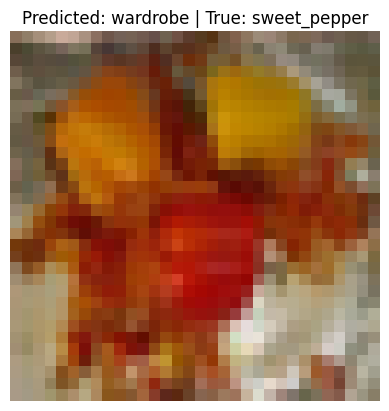

In [44]:
test_img, test_target = test_dataset[563]

model.eval()
with torch.no_grad():
    test_img = test_img.unsqueeze(0).to(device)
    test_pred = model(test_img)
    test_pred = F.softmax(test_pred, dim=1)

    test_pred = test_pred.cpu().numpy().squeeze()
    test_pred_label = np.argmax(test_pred)

    print(f"Predicted Label: {true_labels[test_pred_label]}")
    print(f"True Label: {true_labels[test_target]}")

    test_img = reverse_transform(test_img.squeeze(), train=False)
    plt.imshow(test_img)
    plt.title(
        f"Predicted: {true_labels[test_pred_label]} | True: {true_labels[test_target]}"
    )
    plt.axis("off")

    plt.show()
